In [84]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.plot import plot_yearly
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric, plot

from source import start_pipeline, create_lockdown_predictors, create_date_predictors, create_holiday_predictors, create_weather_predictors, drop_na

ModuleNotFoundError: No module named 'plotly'

In [19]:
new_weather = pd.read_csv("./data/inputs/weatherdata.csv",parse_dates=['timestamp'],index_col='timestamp')
previous_weather = pd.read_csv("./data/inputs/overall_weather.csv",parse_dates=['date'],index_col='date',dayfirst=True)
bankhols = pd.read_csv('./data/inputs/ukbankholidays.csv',parse_dates=['ukbankhols'])
schoolterms = pd.read_csv('./data/inputs/schoolterms.csv',parse_dates=['date'],dayfirst=True,index_col='date',usecols=['schoolStatus','date'])

#import merged footfall data
footfalldf = pd.read_csv("./data/inputs/LCC_footfall_cleaned_2021.csv",
								  parse_dates=['Date','DateTime'],
								  dtype={"BRCYear": int,"BRCWeekNum":int})

In [20]:
#Resample into daily footfall.
day = footfalldf.groupby( [pd.Grouper(key='DateTime',freq='D')])['Count'].sum().to_frame()
#dayfinal = pd.concat([day,frame],verify_integrity=True)
day = day.drop(day[day['Count'] == 0].index)
#Set frequency to daily
day = day.asfreq('D').dropna()

In [21]:
#Prepare expected column names
processed_data = day.reset_index()
processed_data.columns = ['ds','y']
prelockdown = processed_data.loc[(processed_data.ds < '2020-03-16') & (processed_data.ds >= '2015-01-01')]

lockdown = processed_data.loc[processed_data.ds >= '2020-03-16'].drop(['y'],axis=1)

#future is just a dataset that can be used to predict on.  It can be out of sample or represent a test dataset.  Later modelling won't use this variable name.  Here it's just experimenting with the functionality of Prophet.
future = prelockdown.loc[prelockdown.ds >='2019-01-01'].drop(['y'],axis=1)

13:32:04 - cmdstanpy - INFO - Chain [1] start processing
13:32:05 - cmdstanpy - INFO - Chain [1] done processing


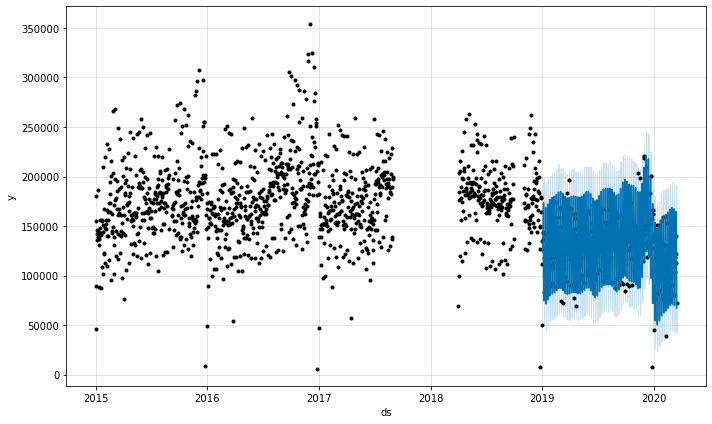

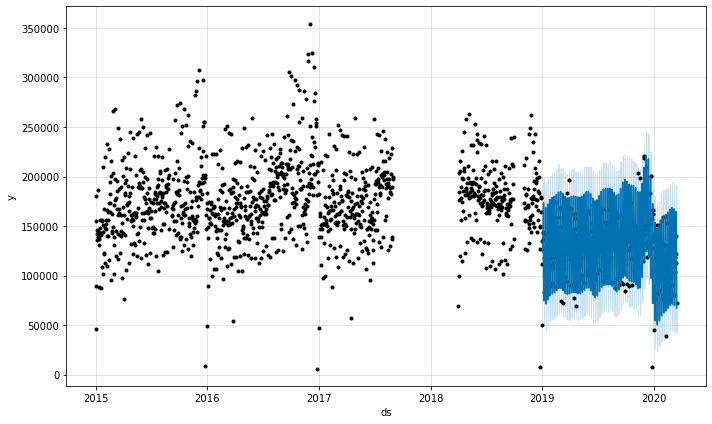

In [22]:
#Define Prophet model
model = Prophet()

#Fit the model
model.fit(prelockdown)

#use the model to make a forecast
forecast = model.predict(future)

model.plot(forecast)

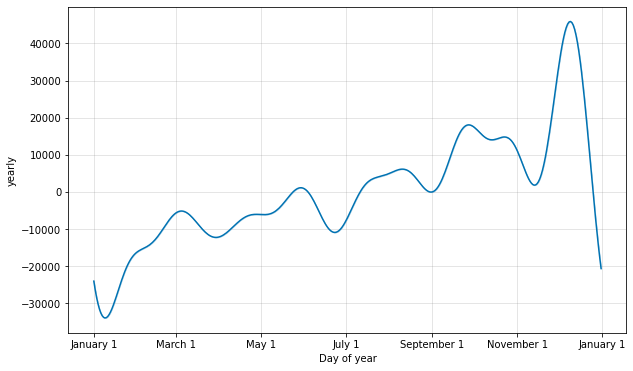

In [38]:
yearly_seasonality = plot_yearly(model)

In [24]:
#Evaluation of model.  Training dataset set as everything prior to 1st January 2019, test as everything after but prior to the start of lockdown
train = prelockdown.loc[prelockdown.ds <'2019-01-01']
test = prelockdown.loc[prelockdown.ds >='2019-01-01'].drop(['y'],axis=1)

#Define Prophet model
model = Prophet()

#Fit the model
model.fit(train)

#use the model to make a forecast
forecast = model.predict(test)

#calculate MAE between expected and predicted values
test_y = prelockdown.loc[prelockdown.ds >='2019-01-01']
y_true = test_y['y'].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true,y_pred)
print('MAE: %.3f' % mae)

13:32:10 - cmdstanpy - INFO - Chain [1] start processing
13:32:10 - cmdstanpy - INFO - Chain [1] done processing


MAE: 17635.286


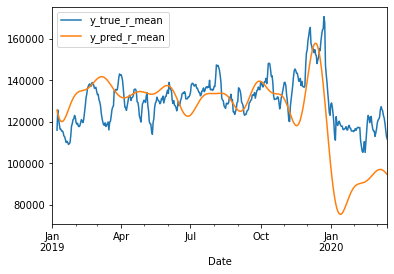

In [34]:
plotdf = pd.DataFrame({'Date': test_y['ds'], 'y_true':y_true,'y_pred':y_pred})
plotdf.set_index(['Date'],inplace=True)

plotdf['y_true_r_mean'] = plotdf['y_true'].rolling(7).mean()
plotdf['y_pred_r_mean'] = plotdf['y_pred'].rolling(7).mean()

plotdf.drop(['y_pred','y_true'],axis=1, inplace=True)


fig = plotdf.plot()

In [77]:



#Define Prophet model
model = Prophet()
initial_df = prelockdown.loc[prelockdown['ds'] < '2019-01-01']
#Fit the model
model.fit(prelockdown)



initial = len(prelockdown.loc[prelockdown.ds < '2019-01-01'])
df_cv = cross_validation(model,initial=f'730 days', horizon='180 days',period='30 days', parallel='processes')
df_p = performance_metrics(df_cv)
df_p

16:16:53 - cmdstanpy - INFO - Chain [1] start processing
16:16:54 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,21 days,4.960520e+08,22272.224413,17064.464684,0.168220,0.098692,0.117542,0.815752
1,22 days,5.054114e+08,22481.357788,17185.361558,0.169331,0.098443,0.118264,0.810382
2,23 days,5.120007e+08,22627.432944,17253.271361,0.169325,0.098443,0.118142,0.810501
3,24 days,4.811020e+08,21934.036561,17129.814834,0.121476,0.099062,0.114750,0.808592
4,25 days,4.917424e+08,22175.264463,17437.036987,0.120820,0.099782,0.116303,0.806683
...,...,...,...,...,...,...,...,...
155,176 days,1.264035e+09,35553.276850,29441.572992,0.218323,0.182478,0.211812,0.500000
156,177 days,1.237681e+09,35180.685380,29125.153375,0.213758,0.180022,0.209707,0.513769
157,178 days,1.226395e+09,35019.925602,29001.961699,0.212385,0.178346,0.209087,0.518542
158,179 days,1.209493e+09,34777.760596,28652.665591,0.210122,0.173849,0.206510,0.529099


(0.0, 1.0)

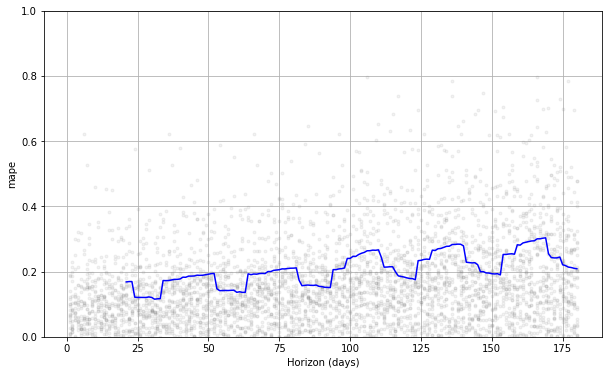

In [83]:
#msefig = plot_cross_validation_metric(df_cv, metric='mse')
#rmsefig = plot_cross_validation_metric(df_cv, metric='rmse')
#maefig = plot_cross_validation_metric(df_cv, metric='mae')
mapefig = plot_cross_validation_metric(df_cv, metric='mape')
ax = mapefig.gca()
ax.set_ylim([0,1])

In [ ]:
processed_data = (day
                          .pipe(start_pipeline)
                          .pipe(create_lockdown_predictors)
                          .pipe(create_date_predictors)
                          .pipe(create_holiday_predictors,bankhols,schoolterms)
                          .pipe(create_weather_predictors, new_weather, previous_weather)
                          .pipe(drop_na))

processed_data = processed_data.loc[:,['Count','wday_Saturday','wday_Sunday','mean_temp','wind_speed','rain','bank_hols','schoolholidays']]

regressors = processed_data.columns
regressors = regressors.tolist()
regressors.remove('Count')

#Prepare expected column names
processed_data = processed_data.reset_index()
processed_data = processed_data.rename(columns={'key_0':'ds','Count':'y'})

prelockdown = processed_data.loc[processed_data.ds < '2020-03-16']
lockdown = processed_data.loc[processed_data.ds >= '2020-03-16'].drop(['y'],axis=1)

cols_to_scale = ['mean_temp', 'wind_speed', 'rain']

#Evaluation of model
train = prelockdown.loc[prelockdown.ds <'2019-01-01']
test = prelockdown.loc[prelockdown.ds >='2019-01-01'].drop(['y'],axis=1)

train.loc[:,cols_to_scale] = min_max_scaler.fit_transform(train.loc[:,cols_to_scale])

#Define Prophet model
model = Prophet()
for r in regressors:
	model.add_regressor(r)
#Fit the model
model.fit(train)

test.loc[:,cols_to_scale] = min_max_scaler.transform(test.loc[:,cols_to_scale])
#use the model to make a forecast
forecast = model.predict(test)

#calculate MAE between expected and predicted values
future_y = prelockdown.loc[prelockdown.ds >='2019-01-01']
y_true = future_y['y'].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true,y_pred)
print('MAE: %.3f' % mae)